__1. Simulating short rate paths under one-factor Hull-White model__

The dynamics of the short rate under one-factor Hull-White model is governed by the following SDE: 

$$ dr_t = (\theta(t) - a \cdot r_t)dt + \sigma \cdot dW_t $$

which has the below solution: 

$$ r_t = r_s e^{-a(t-s)} + \alpha(t) - \alpha(s) e^{-a(t-s)} + \sigma \int^{t}_{s} e^{-a(t-u)} dW_{u} $$

where: 

$$ \alpha(t) = F(0,t) + \frac{\sigma^2}{2a^2}(1 - e^{-at})^2 $$

and $\sigma \int^{t}_{s} e^{-a(t-u)} dW_{u}$ is a stochastic integral, distributed normally with mean zero and variance equal to:

$$\mathbf{V} \left[\sigma \int^{t}_{s} e^{-a(t-u)} dW_{u} \right] = \sigma^2 \int^{t}_{s} e^{-2a(t-u)} du = \frac{\sigma^2}{2a}(1 - e^{-2a(t-s)})$$

The above solution for $r_t$ implies that the short rate should be simulated pathwise and not by direct simulation. This makes code vectorization more challenging and therefore increases computational intensity.

In the expression for $\alpha(t)$ above, $F(0,t)$ is the instantaneous forward rate defined as: 

$$F(0, t) = \lim_{T \to t} f(0, t, T)$$

since:

$$ f(t, T_1, T_2) = - \frac{\ln{P(t, T_2)} - \ln{P(t, T_1)}}{T_2 - T_1} $$

Instantaneous forward rates are related to finite-maturity spot rates $i(t, T)$ via the following equation:

$$ F(t, T) = i(t, T) + (T-t) \frac{\partial i(t,T)}{\partial T} $$

We start by using cubic spline in order to interpolate between the given nodes of the zero curve. Based on that standardized grid, we then calculate a series of $f(0,t,T)$ where $(T-t)$ is always equal to the distance between the nearest nodes. At this point, it is important to note that in our work, we approximate $F(0,t)$ with $f(0,t,T)$. While for large $(T-t)$ and steep zero curves this appoximation is relatively crude, it is becoming better as we adopt the finer grid. This approximation, however, is the reason why the below bond pricing function reproduces zero coupon bond prices, observed at $t = 0$, with a small error.

$$ P(t,T) = \mathbf{E}^\mathbf{Q}[e^{-\int^{T}_{t}r(s)ds} | \mathcal{F}_t] $$

One of the first issues that we had to solve was that the provided zero curve was relatively flat at the long end and hence cubic spline method was producing negative slope at several points, violating monotonicity of the zero curve. This in turn led to huge swings in the foward rate curve, with some points approaching zero. We solved this by using quadratic interpolation, which preserved the property of the zero rate being twice differentiable.

| $T$   | $r_0$ | 0.5 | 1.0 | 3.0 | 5.0 | 10.0 |
| ------| ----- |---- |---- |---- |---- |---- |
| $i(T)$    | 0.01  |0.012  |0.015  |0.02  |0.025  |0.03  |

The resulting term structure of interest rates is presented below.

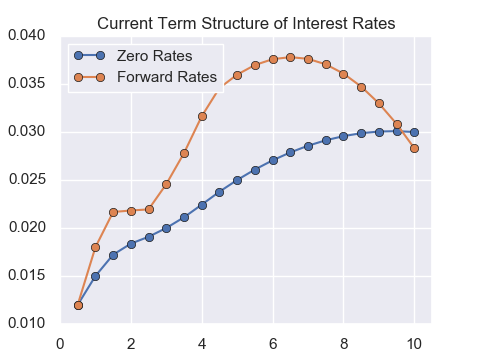

In [1614]:
Image('Current Term Structure.png')

Below we present a sample of 50 short rate paths that we generated and highlight the average path (among the 10,000 total), where all stochasticity is eliminated, in red. It can be observed that the average path lies very close and has similar shape to the forward curve. This effect has roots in the parametrization of the model:

$$ \theta(t) = \frac{\partial F(0,t)}{\partial t} + aF(0,t) + \frac{\sigma^2}{2a}(1 - e^{-2at})$$

Ignoring the last term in the above equation, it implies that the drift of the process for r at time t is $\frac{\partial F(0,t)}{\partial t} + a[F(0,t) - r_t]$. Therefore, absent the last term, on average r should follow the slope of the initial instantaneous forward rate curve and when it deviates from that curve, it reverts back to it at rate a. While normally the last term would be fairly small, in our setting $\sigma$ was calibrated to the relatively large value of 0.02, which leads to the last term adding around 50bps to the drift in the 7 year point, as an example. Therefore, our average path for short rate $r_t$ actually overshoots the forward rate curve at the long end. 

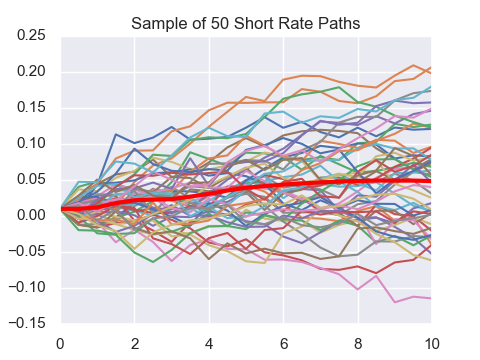

In [1631]:
Image('Sample Short Rate Paths.png')

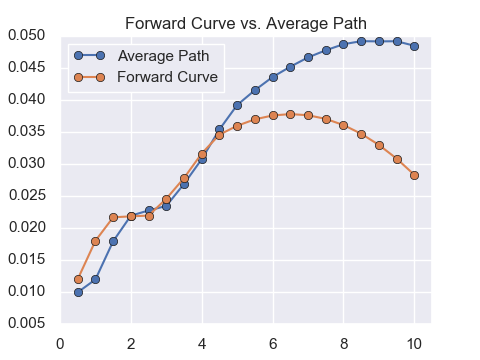

In [1647]:
Image('Forward Curve vs. Average Path.png')

__2. Generating discount factors consistent with the Hull-White model__

Once we simulate a path of the short rate, we can generate a set of discount factors at each simulation date using the formula: 

$$ P(t,T) = A(t,T)e^{-B(t,T)r(t)} $$

where:

$$ A(t,T) = \frac{P(0,T)}{P(0,t)} \cdot exp\left(B(t,T)F(0,t) - \frac{\sigma^2}{4a} B(t,T)^2(1-e^{-2at}) \right) $$

$$ B(t,T) = \frac{1}{a}(1 - e^{-a(T-t)}) $$

and the forward bond price is equal to: 

$$ \frac{P(0,T)}{P(0,t)} = e^{-f(0, t, T)(T-t)} = \frac{e^{-i(0,T) \cdot T}}{e^{-i(0,t) \cdot t}} $$

Since Hull-White belongs to the family of equilibrium models, it should reproduce the prices of zero-coupon bonds $P(0,T)$, observed at $t=0$, exactly.

$$ P(t,T) = \mathbf{E}^\mathbf{Q}[e^{-\int^{T}_{t}r(s)ds} | \mathcal{F}_t] $$

While in the chart below one can see the difference between observed and simulated prices, it should be attributed to the error in approximating $F(0,t)$ with $f(0,t,T)$, as mentioned above.

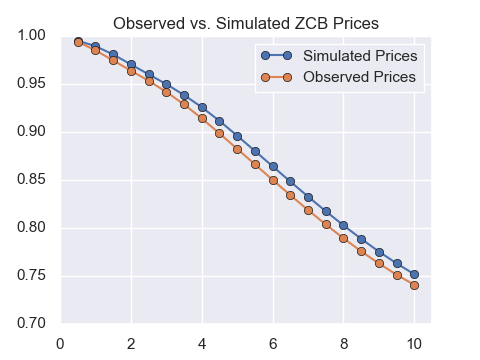

In [1639]:
Image('Observed vs. Simulated ZCB Prices.png')

__3. Calculating mark-to-market of an interest rate swap under single curve framework__

Since we are asked to operate under single curve framework, the value of an interest rate swap for a fixed rate receiver (we assumed that was the direction of our position in the swap) can be found using the below formula:

$$ V^{receive}(t) = V^{fix}(t) - V^{float}(t) = \sum^{n}_{i=m+1} \tau_i \cdot K \cdot P(t, T_i) - \sum^{n}_{i=m+1} \tau_i \cdot L(t, T_{i-1}, T_i) \cdot P(t, T_i) $$

where $\tau_i$ is the length of $i$-th payment period, $L(t, T_{i-1}, T_i)$ is forward LIBOR rate and K is the agreed upon swap rate. Below we demonstrate that our pricing function produces the correct value of almost zero (as a share of notional) for the given K and the provided zero curve.

In [1612]:
maturity = 10; pmt_freq = 0.5; K = 0.02959;

In [1618]:
irs_mtm(zero_rates, pmt_freq, maturity, K)

0.00026313024790633466

__4. Calculating the distribution of the swap's mark-to-market__

In order to calculate mark-to-market of an interest rate swap at any given node on any path, we need to reconstruct the entire zero curve by using closed formulas for zero coupon bonds from Section 2. We then supply this zero-curve into our swap pricing function to calculate its present value.

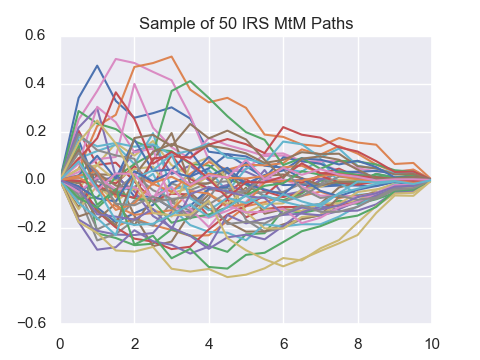

In [1643]:
Image('Sample IRS MtM Paths.png')

__5. Producing EE and 95% PFE Profiles__

Once we have the distribution of the swap's mark-to-market, we apply the below formulas to calculate Expected Exposure and the 95% Potential Future Exposure profiles:

$$ EE_t = \mathbf{E} \left[\max(0, MtM_t) \right]$$
$$ 95\% PFE_t = max[0, p(MtM_t, 95\%)] $$

where $p$ stands for percentile of the distribution.

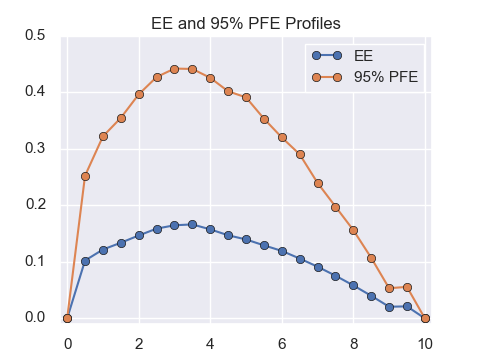

In [1660]:
Image('EE and 95% PFE Profiles.png')

__6. Calculating unilateral CVA__

Assuming independence between the trade's mark-to-market and the counterparty's default probability, CVA charge at $t=0$ is equal to:

$$
CVA(0,T) = -LGD \int_{0}^{T} EE(u) \cdot dPD(u) \approx -LGD \sum^{T}_{i=1} EE(t_i) \cdot P(0, t_i) \cdot PD(t_{i-1}, t_i)
$$

where $EE(u)$ is discounted expected positive exposure and marginal PDs are approximated as:

$$
PD(t_{i-1}, t_i) = F(t_i) - F(t_{i-1}) \approx \exp{\left(-\frac{s_{t_{i-1}}t_{i-1}}{LGD} \right)} - \exp{ \left( -\frac{s_{t_{i}}t_{i}}{LGD} \right)}
$$

where $F(t)$ is the cumulative default probability of the default driven by a Poisson process where the default probability for a future period $t$ is given by:

$$ F(t) = 1 - e^{-h \cdot t} $$

Here h defines the hazard rate of default, which is the conditional default probability in an infinitesimally small period, that can be approximated as:

$$ h \approx \frac{s}{LGD} $$

This approximation is based on the assumption of flat credit spread term structure and CDS premiums being paid continuously as otherwise some functional form for $h$ would have needed to be chosen. The supplied credit curve is sufficiently flat to accommodate the above approximation without adding too much error.

We first interpolate the provided credit curve by using cubic spline. We then convert it into an array of marginal default probabilities $PD(t_{i-1}, t_i)$, which we visualize below.

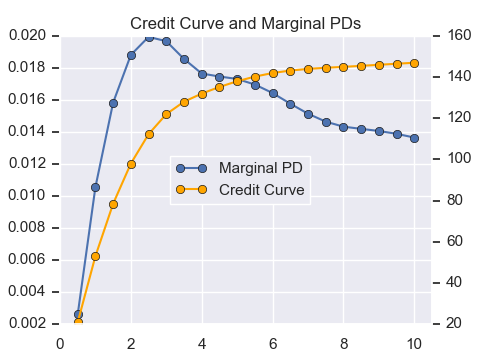

In [1729]:
Image('Credit Curve and Marginal PDs.png')

We then calculate unilateral CVA by using the discretized formula:

In [1772]:
cva(ee, credit_curve, zero_rates, trade_notional = 1) # approximately 1.23% of the notional

-0.012289484526263553

We also double-check the correctness of the magnitude of the calculated CVA charge by using the below approximation. Here, the key simplifying assumption is that $EE$ is constant and is equal to its average value. It tends to be more accurate for swap-like profiles, where the symmetry of the profile helps. It is also more accurate where the default probabilities are relatively constant. Both should be the case in our setting.

$$ CVA \approx -EPE \cdot spread \cdot T $$

In [1774]:
- np.mean(ee.iloc[1:] * zcb_prices) * credit_curve.mean() * 10 # in bps upfront, approximately 1.17% of the notional

-116.99944970102396

__7. Calculating EE, PFE and CVA for a collateralized trade__

According to Gregory (2015), there are two appoaches that allow to incorporate collateral into the above analysis. The first, that we are going to follow in this exercise, is the lookback approach where exposure at $t_i - MPR$ is estimated and then the amount of collateral held at $t_i$ is assumed to equal to that exposure. The second way would be to simply increase the granularity of the grid at which the trade's mark-to-market is calculated with the distance between the nodes equal to the assumed $MPR$. The latter approach, however, is more computationally expensive.

We present the results below. As expected, both EE and 95% PFE profiles now lie much lower and the resulting CVA is approximately 10 times lower. 

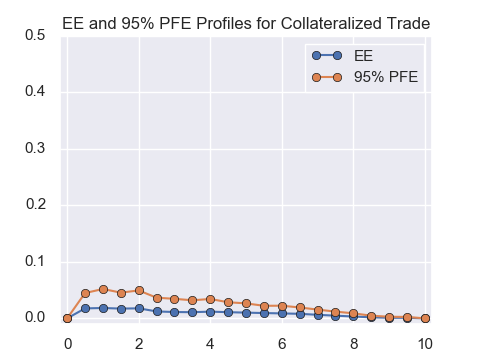

In [1731]:
Image('EE and 95% PFE Profiles for Collateralized Trade.png')

In [1771]:
cva(ee_coll, credit_curve, zero_rates, trade_notional = 1) # approximately 0.1% of the notional

-0.0010199736583059898

__8. Calculating CVA under the assumption of stochastic volatility__

We now assume that the short rate $r_t$ follows the below process:

$$ dr_t = (\theta(t) - a \cdot r_t)dt + \sqrt{v_t} \cdot dW_t $$
$$ dv_t = \lambda(\kappa - v_t)dt + \varepsilon \cdot \sqrt{v_t} \cdot dW^v_t $$
$$ dW_t \cdot dW^v_t = 0 $$

Here, we let $v_0 = 0.0004$, $\lambda = 0.005$, $\kappa = 0.0004$ and $\varepsilon = 0.035$. With this parametrization, our volatility time series exhibit the properties commonly found in the real data - relatively high volatility of volatility and strong mean reversion. We set both long term variance and $v_0$ to the same value equal to $\sigma$ from the first part of the assignment so as to make the results comparable. We present the single simulated path that we are going to use below.

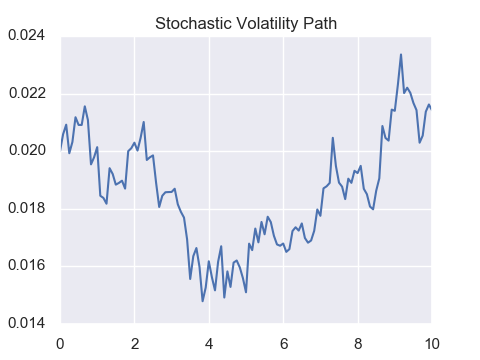

In [1787]:
Image('Stochastic Volatility Path.png')

We then calculate CVA time series using finer 30-day grid and the above volatility path. As expected, since on the selected path the volatility is generally lower than the constant calibrated volatility, our new CVA time series lie below the previously calculated CVA. It is important to note that the below CVA dynamics if the underlying swap trade actually follows its average mark-to-market (EE) path and the credit curve remains static. In reality, none of these assumption would be true and the actual dynamics of CVA would depend on changes in EE profile (and, therefore, on all risk factors driving the trade's mark-to-market) and the credit curve. In the case of an interest rate swap in the single curve framework and the Hull-White model, there would only be one risk factor - the short rate. CVA, however, doesn't represent linear exposure to the underlying factor, but can be thought of as an exotic option. Therefore, it would also have non-zero sensitivities, such as $\frac{\partial CVA}{\partial \sigma}$, which can be hedged by using interest rate swaptions.

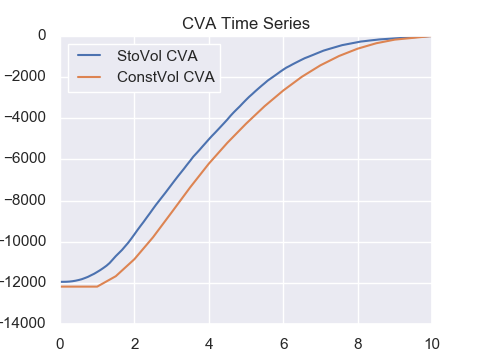

In [1881]:
Image('CVA Time Series.png') #assuming $1,000,000 trade notional

__Appendix: Python code__

In [245]:
import numpy as np
import pandas as pd

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [1061]:
# Parameters of HW1F
a = 0.01 # speed of mean-reversion
sigma = 0.02 # short-rate volatility
Nsim = 10000 # number of simulated paths

In [297]:
from scipy.interpolate import interp1d

In [1593]:
# Use cubic spline interpolator to obtain intermediate points on the zero curve

given_tenors = np.array([0, 0.5, 1., 3., 5., 10.]) #we start with zero to widen interpolation range
given_zero_rates = np.array([0.01, 0.012, 0.015, 0.02, 0.025, 0.03]) #downward sloping long end was produced with i(0,10)=0.03
zero_curve = interp1d(given_tenors, given_zero_rates, kind = 'quadratic')

In [1594]:
# Produce arrays containing zero rates, associated DFs and forward rates f(0, T1, T2)
tenors = np.linspace(0.5, 10, 20)
zero_rates = zero_curve(tenors)
zero_rates = pd.Series(zero_rates, index = tenors)

In [1595]:
def zero_to_forward(zero_rates):

    tenors = zero_rates.index
    
    if zero_rates.shape[0] > 1:
        forward_rates = np.array([(zero_rates.iloc[i]*tenors[i] - zero_rates.iloc[i-1]*tenors[i-1])/(tenors[i] - tenors[i-1]) 
                          for i in range(1, tenors.shape[0])])
        forward_rates = np.insert(forward_rates, 0, zero_rates.iloc[0])
        forward_rates = pd.Series(forward_rates, index = tenors)
    else:
        forward_rates = zero_rates
    
    return forward_rates

In [1596]:
def zero_to_df(zero_rates):
  
    discount_factors = np.exp(-zero_rates * zero_rates.index)
    
    return discount_factors

In [1597]:
zcb_prices = zero_to_df(zero_rates)
forward_rates = zero_to_forward(zero_rates)

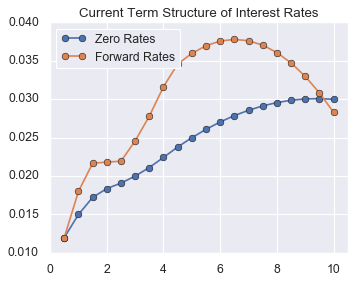

In [1598]:
# Visualize the resulting spot and forward rate curve
#term_structure = plt.figure()
plt.plot(tenors, zero_rates, marker = 'o');
plt.plot(tenors, forward_rates, marker = 'o');
plt.title('Current Term Structure of Interest Rates');
plt.xlim(0, 10.5);
#plt.xlabel('Tenor');
#plt.ylabel('Interest Rate, %');
plt.legend(labels = ['Zero Rates', 'Forward Rates'], loc = 2);
#plt.rcParams['figure.figsize'] = [4.8, 3.6];
plt.savefig('Current Term Structure.png');

In [1599]:
def alpha(forward_rates, a, sigma, t, sto_vol = False, vol_path = None):
    
    step = forward_rates.index[-1] - forward_rates.index[-2]
    
    if sto_vol == False:
        if t > step:
            alpha_t = forward_rates[t - step] + sigma**2*(1 - np.exp(-a*t))**2/(2*a**2)
        else: alpha_t = 0.01
    
    if sto_vol == True:
        if t > step:
            alpha_t = forward_rates[t - step] + vol_path[t]**2*(1 - np.exp(-a*t))**2/(2*a**2)
        else: alpha_t = 0.01
    
    return alpha_t

In [1600]:
def rt(rs, s, t, a, sigma, forward_rates, sto_vol = False, vol_path = None):
    
    if sto_vol == False:
        rt = rs * np.exp(-a*(t-s)) + alpha(forward_rates, a, sigma, t) \
        - alpha(forward_rates, a, sigma, s) * np.exp(-a*(t-s)) \
        + np.random.normal(0, np.sqrt(sigma**2/(2*a) * (1 - np.exp(-2*a*(t-s)))))
    
    if sto_vol == True:
        rt = rs * np.exp(-a*(t-s)) + alpha(forward_rates, a, sigma, t) \
        - alpha(forward_rates, a, sigma, s) * np.exp(-a*(t-s)) \
        + np.random.normal(0, np.sqrt(vol_path[t]**2/(2*a) * (1 - np.exp(-2*a*(t-s)))))
    
    return rt

In [1601]:
# Simulates a single short rate paths under Hull-White model
def sim_hw_path(forward_rates, a, sigma, sto_vol = False, vol_path = None):
    
    path = pd.Series(index = np.insert(forward_rates.index, 0, 0), dtype = 'float64')
    path[0] = 0.01
    
    for k in range(1, path.index.shape[0]):
        path.iloc[k] = rt(path.iloc[k-1], path.index[k-1], path.index[k], a, sigma, forward_rates)
    path = path.iloc[1:]
    
    return path

In [1602]:
# Simulates an arbitrary number of paths
def simulate_hull_white(forward_rates, a, sigma, Nsim, sto_vol = False, vol_path = None):
    
    paths = pd.DataFrame(index = forward_rates.index, columns = ['Path %s' %n for n in range(1, Nsim + 1)])
    for n in range(1, Nsim + 1):
        paths['Path %s' %n] = sim_hw_path(forward_rates, a, sigma)
    
    return paths

In [1627]:
# Simulate 10,000 short rate paths under one-factor Hull-White model and save them into a data frame
short_rate_paths = simulate_hull_white(forward_rates, a, sigma, Nsim)

In [1628]:
start = pd.DataFrame(0.01, index = [0], columns = short_rate_paths.columns)
short_rate_paths = pd.concat([start, short_rate_paths], ignore_index = False)

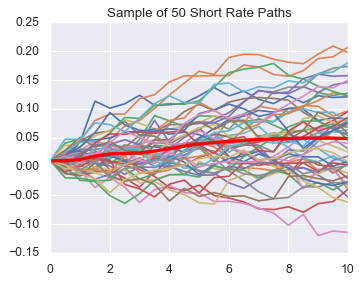

In [1629]:
# Visualize 50 short rate paths
short_rate_paths.iloc[:,:50].plot(legend = None);
short_rate_paths.mean(axis = 1).plot(color = 'red', linewidth = 3);
plt.xlim(0, 10);
plt.title('Sample of 50 Short Rate Paths');
plt.savefig('Sample Short Rate Paths.png');

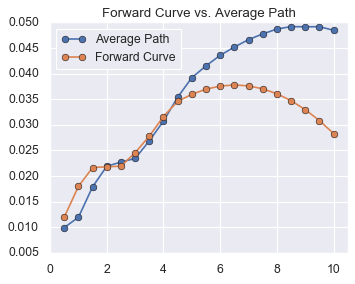

In [1646]:
short_rate_paths.iloc[1:, :].mean(axis = 1).plot(marker = 'o');
plt.plot(tenors, forward_rates, marker = 'o');
plt.legend(labels = ['Average Path', 'Forward Curve'], loc = 2);
plt.xlim(0, 10.5);
plt.title('Forward Curve vs. Average Path');
plt.savefig('Forward Curve vs. Average Path.png');

In [1606]:
def hull_white_df(a, sigma, t, T, rt, zero_rates_at_t_0):
    
    forward_rates = zero_to_forward(zero_rates_at_t_0)
    
    P0T = np.exp(-zero_rates_at_t_0[round(T, 5)]*T)
    if t > 0:
        P0t = np.exp(-zero_rates_at_t_0[round(t, 5)]*t)
    else:
        P0t = 1
    
    forward_bond_price = P0T/P0t
    
    BtT = (1/a)*(1 - np.exp(-a*(T-t)))
    if t > 0:
        F0t = forward_rates[round(t, 5)]
    else:
        F0t = 0
    AtT = forward_bond_price * np.exp(BtT * F0t - (sigma**2/(4*a)) * BtT**2 * (1 - np.exp(-2*a*t)))
    
    PtT = AtT * np.exp(-BtT*rt)
    
    return PtT

In [1607]:
# Generate the whole zero curve for each step on the path of the short rate 
def curve_for_step(a, sigma, zero_rates_at_t_0, t, rt):
    
    series = pd.Series(0, index = zero_rates_at_t_0.index)
    times = series.loc[t:].index.tolist()
    T = zero_rates_at_t_0.index[-1]

    PtT = [hull_white_df(a, sigma, time, T, rt, zero_rates_at_t_0) for time in times][::-1]
    PtT = pd.Series(PtT, index = times)
    
    zero_curve = - np.log(PtT) / PtT.index
    zero_curve = zero_curve.iloc[1:]
    
    return zero_curve

In [1608]:
def price_hw_zcb(short_rate_paths, t, T):
    
    PtT = np.exp(-0.5 * short_rate_paths.loc[t+0.5:T,:].apply(np.sum, axis = 0)).mean()
    
    return PtT

In [1609]:
P0T = pd.Series([price_hw_zcb(short_rate_paths, 0, T) for T in zcb_prices.index], index = zcb_prices.index)

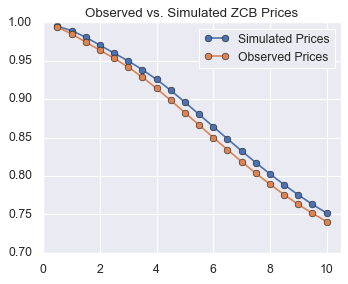

In [1637]:
plt.plot(tenors, P0T, marker = 'o');
plt.plot(tenors, zcb_prices, marker = 'o');
plt.xlim(0, 10.5)
plt.legend(labels = ['Simulated Prices', 'Observed Prices'], loc = 1)
plt.title('Observed vs. Simulated ZCB Prices')
plt.savefig('Observed vs. Simulated ZCB Prices.png')

In [1611]:
# Calculate MtM of an IRS under single-curve framework, assuming short rate being paid on the floating leg
# We assume that the MtM is calculated from the perspective of a fixed rate receiver

def irs_mtm(zero_rates, pmt_freq, maturity, K):
    
    if int(maturity / pmt_freq - 1) > 0:
        n_payments = int(maturity / pmt_freq - 1) #to account for 0 indexing in pandas Series
    else:
        n_payments = 1
        
    # we only need to leave the nearest 'round' payment date
    zero_curve = zero_rates.iloc[(zero_rates.index%0.5 == 0).astype(bool)]
        
    df = zero_to_df(zero_curve)
    forward_rates = zero_to_forward(zero_curve)
    
    fixed_leg = df.iloc[:n_payments] * pmt_freq * K
    floating_leg = df.iloc[:n_payments] * pmt_freq * forward_rates.iloc[:n_payments]
    
    pv_fixed_leg = fixed_leg.sum()
    pv_floating_leg = floating_leg.sum()
    
    MtM = pv_fixed_leg - pv_floating_leg
    
    return MtM

In [800]:
def simulate_irs_mtm(a, sigma, zero_rates_at_t_0, short_rate_paths, pmt_freq, maturity, K):
    
    irs_mtm_paths = pd.DataFrame(0, index = short_rate_paths.index, columns = short_rate_paths.columns)
    paths = short_rate_paths.columns
    nodes = short_rate_paths.index.tolist() # MtM at terminal date is zero
    
    for path in paths:
        zero_curves = [(curve_for_step(a, sigma, zero_rates_at_t_0, step, short_rate_paths.loc[step, path]), step) 
                      for step in nodes] # list of tuples containing zero curves for each step on that path
        irs_mtm_paths.loc[:, path] = [irs_mtm(curve[0], pmt_freq, maturity - curve[1], K) for curve in zero_curves]
    
    return irs_mtm_paths

In [612]:
irs_mtm_paths = simulate_irs_mtm(a, sigma, zero_rates, short_rate_paths, pmt_freq, maturity, K)

In [986]:
zeros = pd.DataFrame(0, index = [0], columns = irs_mtm_paths.columns)
irs_mtm_paths = pd.concat([zeros, irs_mtm_paths], ignore_index = False)

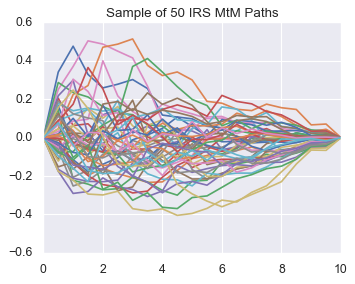

In [1642]:
irs_mtm_paths.iloc[:, :50].plot(legend = None)
plt.xlim(0, 10)
plt.title('Sample of 50 IRS MtM Paths')
plt.savefig('Sample IRS MtM Paths.png')

In [737]:
import scipy.stats as stats

In [1752]:
def exposure_profile(mtm_paths, percentile = 95):
    
    ee = mtm_paths.apply(lambda x : x[x >= 0].mean(), axis = 1)    
    pfe = mtm_paths.apply(lambda x: stats.scoreatpercentile(x[x >= 0], percentile), axis = 1)

    return ee, pfe

In [1757]:
ee, pfe = exposure_profile(irs_mtm_paths.iloc[ :-1, : ])

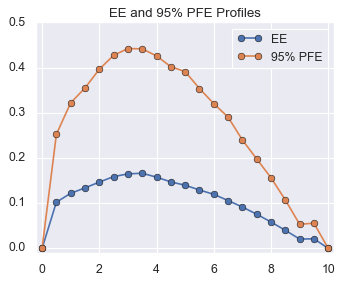

In [1655]:
ee.plot(marker = 'o')
pfe.plot(marker = 'o')
plt.legend(['EE','95% PFE'])
plt.xlim(-0.2, 10.2)
plt.ylim(-0.01, 0.5)
plt.title('EE and 95% PFE Profiles')
plt.savefig('EE and 95% PFE Profiles.png')

In [1831]:
# Input data for CVA calculation
LGD = 0.4 
grid = np.linspace(0, 10, 11)
spread = np.array([0., 53., 98., 122., 132., 138., 142., 144., 145., 146., 147])
credit_spread = pd.Series(spread, index = grid)

In [1832]:
given_credit_curve = CubicSpline(grid, spread)

In [690]:
credit_curve = pd.Series(given_credit_curve(tenors), index = tenors)

In [1841]:
def spread_to_pd(credit_curve, LGD):
    
    time = credit_curve.index
    marginal_pd = [0] * (credit_curve.index.shape[0] - 1)
    
    for i in range(1, credit_curve.index.shape[0]):
        marginal_pd[i-1] = np.exp(-credit_curve.iloc[i-1] * time[i-1] / (LGD * 10000)) - np.exp(-credit_curve.iloc[i] * time[i] / (LGD * 10000))
        
    marginal_pd = pd.Series(marginal_pd, index = credit_curve.index[1:])
    
    return marginal_pd

In [696]:
PD = spread_to_pd(credit_curve, LGD)

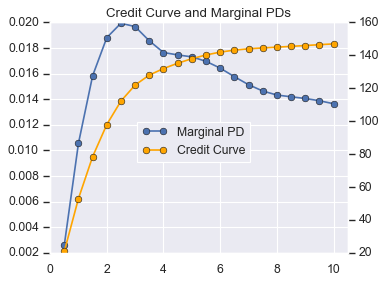

In [1728]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots()
# make a plot
ax.plot(tenors, PD, marker = "o")
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(tenors, credit_curve, color = "orange", marker = "o")
plt.xlim(0, 10.5);
fig.legend(labels = ['Marginal PD', 'Credit Curve'], loc = 10);
plt.grid(False)
plt.title('Credit Curve and Marginal PDs');
plt.savefig('Credit Curve and Marginal PDs.png');

In [1687]:
# To calculate CVA, we assume $100,000,000 notional on the swap to arrive at USD figure
CVA = - 100000000 * LGD * np.sum(EE.iloc[1:] * zcb_prices * PD)

In [1688]:
CVA

-1228948.4526263552

In [1713]:
def cva(exposure, credit_curve, zero_curve, trade_notional = 100000000, lgd = 0.4):
    
    df = zero_to_df(zero_curve)
    pd = spread_to_pd(credit_curve, LGD)
    cva = - trade_notional * lgd * np.sum(exposure * df * pd)
    
    return cva

In [1714]:
cva(ee, credit_curve, zero_rates)

-1228948.4526263552

In [877]:
# Calculate zero and forward rates at t_i - MPR
mpr = round(10/252, 5)
mpr_grid = np.linspace(0.5, 10, 20) - mpr

# Contains all nodes including both t - MPR and t itself
grid = mpr_grid.tolist() + np.linspace(0.5, 10, 20).tolist()
grid = np.sort(np.array(grid))

zero_rates_mpr = zero_curve(grid)

zero_rates_mpr = pd.Series(zero_rates_mpr, index = grid)
forward_rates_mpr = zero_to_forward(zero_rates_mpr)

In [878]:
short_rate_paths_mpr = simulate_hull_white(forward_rates_mpr, a, sigma, Nsim)

In [997]:
short_rate_paths_mpr = pd.concat([zeros, short_rate_paths_mpr], ignore_index = False)

(0, 10)

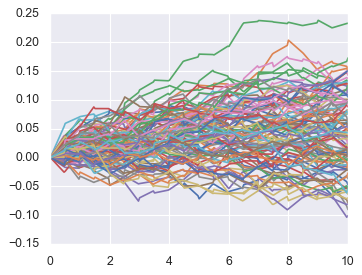

In [1669]:
short_rate_paths_mpr.iloc[:,:100].plot(legend = None)
plt.xlim(0, 10)

In [1099]:
irs_mtm_paths_mpr = simulate_irs_mtm(a, sigma, zero_rates_mpr, 
                                     short_rate_paths_mpr, pmt_freq, maturity, K)

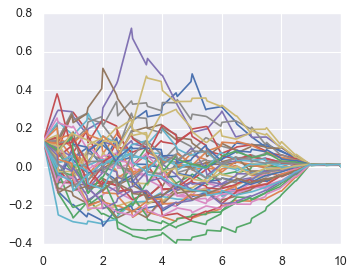

In [1668]:
irs_mtm_paths_mpr.iloc[:, :50].plot(legend = None)

In [1101]:
mpr_nodes = mpr_grid.tolist()
st_nodes = np.linspace(0.5, 10, 20).tolist()

In [1102]:
exp_at_t = irs_mtm_paths_mpr.loc[st_nodes, :]
exp_at_t_mpr = irs_mtm_paths_mpr.loc[mpr_nodes, :]

uncoll_exposure = pd.DataFrame(exp_at_t.values - exp_at_t_mpr.values, 
                               index = exp_at_t.index, columns = exp_at_t.columns)

In [1676]:
ee_coll, pfe_coll = exposure_profile(uncoll_exposure)

In [1678]:
ee_coll[-1] = 0; pfe_coll[-1] = 0;

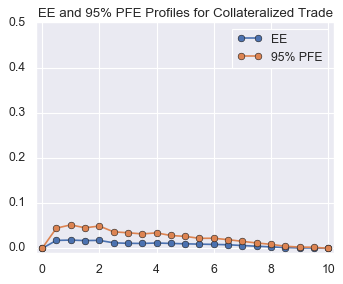

In [1730]:
ee_coll.plot(marker = 'o')
pfe_coll.plot(marker = 'o')
plt.legend(['EE','95% PFE'])
plt.xlim(-0.2, 10.2)
plt.ylim(-0.01, 0.5)
plt.title('EE and 95% PFE Profiles for Collateralized Trade')
plt.savefig('EE and 95% PFE Profiles for Collateralized Trade.png')

In [1770]:
cva(ee_coll, credit_curve, zero_rates, trade_notional = 1)

-0.0010199736583059898

In [1202]:
step = 30/365; T = 10; grid_30d = np.round(np.linspace(0, 10, 121), 4); v0 = 0.0004; l = 0.005; k = 0.0004; e = 0.035;

In [1183]:
def sim_vt(v0, lmbd, kappa, epsilon, T, step):
    
    nsteps = int(T / step)
    vt_path = pd.Series(0, index = np.linspace(0, T, nsteps))
    vt_path.iloc[0] = v0
    
    for i in range(1, nsteps):
        dvt = lmbd * (kappa - vt_path.iloc[i-1]) * step + epsilon * np.sqrt(vt_path.iloc[i-1]) * np.random.normal(0, epsilon)
        vt_path.iloc[i] = vt_path.iloc[i-1] + dvt
    
    vt_path.index = np.round(vt_path.index.values, 4)
    
    return vt_path

In [1184]:
vt = sim_vt(v0, l, k, e, T, step)

In [1185]:
s = np.sqrt(vt)

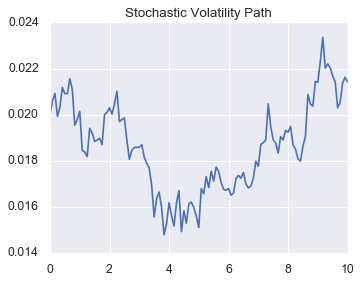

In [1786]:
s.plot(legend = None)
plt.xlim(0, 10)
plt.title('Stochastic Volatility Path')
plt.savefig('Stochastic Volatility Path.png')

In [1211]:
zero_30d = pd.Series(zero_curve(grid_30d), index = grid_30d)

In [1213]:
fwd_30d = zero_to_forward(zero_30d)

In [1220]:
short_rate_paths_30d = simulate_hull_white(fwd_30d, a, sigma, Nsim, sto_vol = True, vol_path = s)

(0, 10)

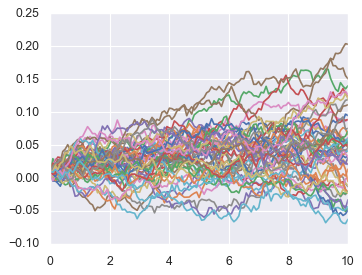

In [1662]:
short_rate_paths_30d.iloc[:, :50].plot(legend = None)
plt.xlim(0, 10)

In [1234]:
irs_mtm_paths_30d = simulate_irs_mtm(a, sigma, zero_30d, short_rate_paths_30d, pmt_freq, maturity, K)

(0, 10)

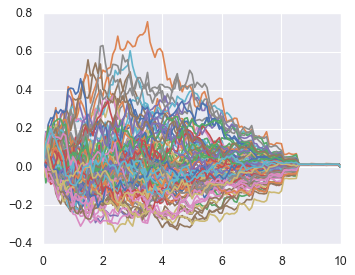

In [1663]:
irs_mtm_paths_30d.plot(legend = None)
plt.xlim(0, 10)

In [1807]:
def cva_time_series(mtm_paths, credit_curve, zero_curve, trade_notional = 1000000, lgd = 0.4):
    
    cva = pd.Series(0, index = mtm_paths.index)
    ee = mtm_paths.apply(lambda x : x[x >= 0].mean(), axis = 1)
    mpd = spread_to_pd(credit_curve, lgd)
    df = zero_to_df(zero_curve)
    
    for t in mtm_paths.index:
        exposure_t = mtm_paths
        df_t = df[t:]
        pd_t = mpd[t:]
        ee_t = ee[t:]
        cva[t] = - trade_notional * lgd * np.sum(ee_t * df_t * pd_t)
    
    return cva

In [1876]:
credit_curve_30d = pd.Series(given_credit_curve(grid_30d), index = grid_30d)

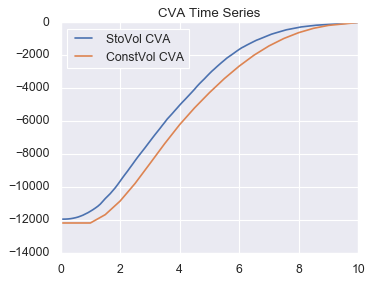

In [1880]:
cva_time_series(irs_mtm_paths_30d, credit_curve_30d, zero_30d).plot()
cva_time_series(irs_mtm_paths.iloc[:-1, :], credit_curve, zero_rates).plot()
plt.legend(labels = ['StoVol CVA', 'ConstVol CVA'], loc = 'best');
plt.title('CVA Time Series')
plt.savefig('CVA Time Series.png')